# Fix topology

## Defining cube states and transformations

Given that one half-face is already solved (let's assume it's in the bottom left half), we now need to fix the topology of the other 3 half-faces to make the them correctly alternating big-small-big-small.  Representing a cube state as a triplet of 4-bits, wlog, let's assume the correct pattern for the 3 faces is:
* 0101 0101 0101

Since we don't want to mess with the bottom-left half-face (and we don't need to), the allowable moves are:
* top-face rotation (barrel-shift the 8-bits of the top face)
* right-half rotation (swap a pair of 4-bit words)

We can simplify transformations between states as a procedure:
1. take a pair of 4-bit words & concatenate
2. barrel-shift by some amount
3. split into a new pair of 4-bit words (make sure each word has 2x0's and 2x1's to ensure that it is still possible to do a right-half rotation).

## Representing algorithms in a graph
### Undirected graph
We can create an undirected graph, where the nodes represent states (triplets of 4-bit words), and the edges represent a pair of top & right rotations that can bring one state to another.  So, for example,

0101 0101 0101 <-> 1010 1010 0101

is a valid edge since we can go 0101+0101 -> (top face) 01010101 -> U -> 10100101 -> (right half) 1010 1010.

### Bipartite graph
But I think it's actually a little bit easier to represent the problem as a bipartite graph, with one type of node representing cube states (triplet of 4-bit words) and the other node type representing a choice of top-face (i.e. one 8-bit word and one 4-bit word).  So as an example:

```mermaid
graph LR
    A["0101\n0101\n0101"] --- B(["01010101\n0101"])
    B --- C["1010\n1010\n0101"]
```

### Solving with Python
Now let's try to create a solver / graph generator in python

In [2]:
from dataclasses import dataclass

Word = str

@dataclass
class State:
    words: tuple[Word]
    def __str__(self) -> str:
        return '/'.join(sorted(self.words))
    def permutations(self) -> set["IntermediateState"]:
        return set([IntermediateState(Word(self.words[0] + self.words[1]), self.words[2]),
                    IntermediateState(Word(self.words[1] + self.words[2]), self.words[0]),
                    IntermediateState(Word(self.words[0] + self.words[2]), self.words[1])])
    def __eq__(self, __value: object) -> bool:
        return sorted(self.words) == sorted(__value.words)
    def __hash__(self):
        return hash(self.words)

def rotate(word, amt):
    return word[amt:] + word[:amt]
def circular_equal(s1, s2):
    if len(s1) != len(s2):
        return False
    return any((s1 == rotate(s2, i) for i in range(len(s2))))
def is_valid_word(word):
    return word.count('0') + 2 * word.count('1') == 6

@dataclass
class IntermediateState:
    top: Word
    bottom: Word
    def __str__(self) -> str:
        return f'{self.top}/{self.bottom}'
    def __eq__(self, other):
        return circular_equal(self.top, other.top) and self.bottom == other.bottom
    def __hash__(self):
        return hash((self.top, self.bottom))
    def permutations(self):
        ret = set()
        for i in range(8):
            t = rotate(self.top, i)
            for l in range(3, 7):
                s = State((t[:l], t[l:], self.bottom))
                if is_valid_word(s.words[0]) and is_valid_word(s.words[1]):
                    ret.add(s)
        return ret

In [3]:
## Construct bipartite graph
nodesA = {}
nodesB = {}
edges = set()
new_nodes = {'': State(['0101', '0101', '0101'])}
for depth in range(999):
    next_new_nodes = {}
    for label, node in new_nodes.items():
        if node in nodesA.values():
            continue
        # nodesA[label] = node
        for i, perm in enumerate(node.permutations()):
            if perm in nodesB.values():
                for k, v in nodesB.items():
                    if v == perm:
                        if k.count('_') < label.count('_'):
                            raise Exception('Found a parity loop! yay!')
                continue
            nodesB[f'{label}_{i}'] = perm
            edges.add((label, f'{label}_{i}'))
            for j, node_a in enumerate(perm.permutations()):
                if node_a in nodesA.values():
                    raise Exception('Found a parity loop! yay!')
                if node_a in nodesA.values() or node_a in new_nodes.values():
                    continue
                if node_a in next_new_nodes.values():
                    child_node = [k for k, v in next_new_nodes.items() if v == node_a][0]
                else:
                    child_node = f'{label}_{i}-{j}'
                    next_new_nodes[child_node] = node_a
                edges.add((child_node, f'{label}_{i}'))
    for label, node in new_nodes.items():
        if node not in nodesA.values():
            nodesA[label] = node
    new_nodes = {k:v for k, v in next_new_nodes.items()}
    if not new_nodes:
        break
for label, node in new_nodes.items():
    if node in nodesA.values():
        continue
    nodesA[label] = node

print(nodesA)
print(nodesB)
print(edges)

{'': State(words=['0101', '0101', '0101']), '_0-0': State(words=('1010', '1010', '0101')), '_0-0_1-0': State(words=('1001', '0110', '1010')), '_0-0_1-0_0-0': State(words=('1010', '0110', '0110')), '_0-0_1-0_0-3': State(words=('0101', '0011', '0110')), '_0-0_1-0_1-0': State(words=('0101', '0011', '1001')), '_0-0_1-0_1-1': State(words=('1001', '1010', '1001')), '_0-0_1-0_0-0_1-0': State(words=('0011', '0011', '1010')), '_0-0_1-0_0-0_1-1': State(words=('1100', '1100', '1010')), '_0-0_1-0_0-3_0-1': State(words=('0110', '1100', '0101')), '_0-0_1-0_0-3_2-2': State(words=('1010', '1100', '0011')), '_0-0_1-0_1-0_2-1': State(words=('1100', '1001', '0101')), '_0-0_1-0_1-0_2-2': State(words=('00100', '111', '0101')), '_0-0_1-0_0-0_1-0_1-2': State(words=('111', '01000', '0011')), '_0-0_1-0_0-3_0-1_1-0': State(words=('111', '00010', '0110')), '_0-0_1-0_0-3_2-2_0-1': State(words=('111', '00001', '1010')), '_0-0_1-0_0-3_2-2_0-4': State(words=('111', '10000', '1010')), '_0-0_1-0_0-3_2-2_1-1': State(wo

{'0101/0101/0101': (0.5, 18), '0101/1010/1010': (0.5, 16), '0110/1001/1010': (0.5, 14), '0110/0110/1010': (0.0, 12), '0011/0101/0110': (0.3333333333333333, 12), '0011/0101/1001': (0.6666666666666666, 12), '1001/1001/1010': (1.0, 12), '0011/0011/1010': (0.0, 10), '1010/1100/1100': (0.2, 10), '0101/0110/1100': (0.4, 10), '0011/1010/1100': (0.6, 10), '0101/1001/1100': (0.8, 10), '00100/0101/111': (1.0, 10), '0011/01000/111': (0.0, 8), '00010/0110/111': (0.14285714285714285, 8), '00001/1010/111': (0.2857142857142857, 8), '10000/1010/111': (0.42857142857142855, 8), '01000/1100/111': (0.5714285714285714, 8), '00010/1001/111': (0.7142857142857143, 8), '00100/1010/111': (0.8571428571428571, 8), '01000/1010/111': (1.0, 8), '0110/10000/111': (0.0, 6), '01000/1001/111': (0.06666666666666667, 6), '00100/1100/111': (0.13333333333333333, 6), '00001/0011/111': (0.2, 6), '10000/1001/111': (0.26666666666666666, 6), '00001/0101/111': (0.3333333333333333, 6), '00010/1010/111': (0.4, 6), '01000/0101/111':

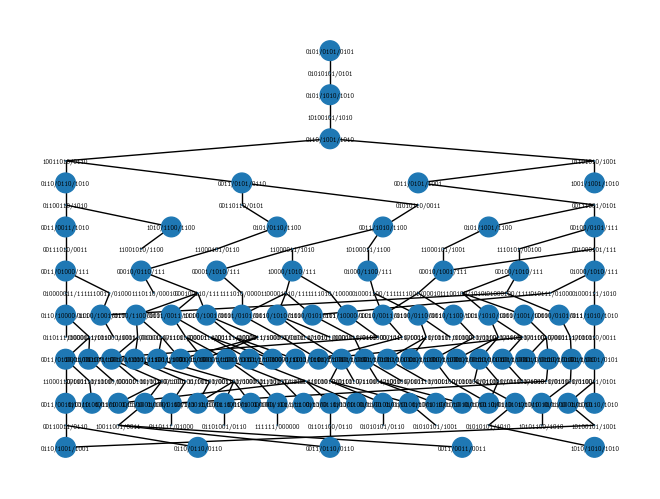

In [4]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

# Create a bipartite graph
B = nx.Graph()
B.add_nodes_from([str(node) for node in nodesA.values()], bipartite=0)
B.add_nodes_from([str(node) for node in nodesB.values()], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(str(nodesA[nodeA]), str(nodesB[nodeB])) for nodeA, nodeB in edges])

# Separate by group
l, r = nx.bipartite.sets(B)
pos = {}

# Update position for node from each group
for depth in range(999):
    sub = [node for lbl, node in nodesA.items() if lbl.count('_') == depth]
    if not sub:
        break
    N = len(sub)
    for index, node in enumerate(sub):
        pos[str(node)] = ((index / (N - 1)) if (N > 1) else 0.5, depth * 2)
for depth in range(1, 999):
    sub = [node for lbl, node in nodesB.items() if lbl.count('_') == depth]
    if not sub:
        break
    N = len(sub)
    for index, node in enumerate(sub):
        pos[str(node)] = ((index / (N - 1)) if (N > 1) else 0.5, depth * 2 - 1)

maxY = max([y for _, y in pos.values()])
pos = {k: (x, maxY - y) for k, (x, y) in pos.items()}

print(pos)
# pos = nx.spring_layout(B)  # positions for all nodes
# pos = graphviz_layout(B, prog="dot")
nx.draw(B, pos=pos, with_labels=True, node_size = [200]*len(l) + [0.1]*len(r), font_size=5)
plt.show()

In [6]:
for label, node in nodesB.items():
    # print(node, node == IntermediateState('00110101', '0011'))
    # if node == IntermediateState('00110101', '0011'):
    if node == IntermediateState('01010101', '1010'):  # Top-face, bottom half-face
        print(label, node)
        break
else:
    raise Exception('Not found')
while True:
    print(node, label)
    if label == '':
        print("Done")
        break
    for a, b in edges:
        if a == label and len(a) > len(b):
            label, node = b, nodesB[b]
            break
        if b == label and len(b) > len(a):
            label, node = a, nodesA[a]
            break
    else:
        raise Exception('No more edges')

_0-0_1-0_1-0_2-2_0-0_1-0_0-1_0-1_1 01010101/1010
01010101/1010 _0-0_1-0_1-0_2-2_0-0_1-0_0-1_0-1_1
0101/0101/1010 _0-0_1-0_1-0_2-2_0-0_1-0_0-1_0-1
01101001/0101 _0-0_1-0_1-0_2-2_0-0_1-0_0-1_0
0101/0110/1001 _0-0_1-0_1-0_2-2_0-0_1-0_0-1
11001010/1001 _0-0_1-0_1-0_2-2_0-0_1-0_0
1001/1010/1100 _0-0_1-0_1-0_2-2_0-0_1-0
11100100/1010 _0-0_1-0_1-0_2-2_0-0_1
00100/1010/111 _0-0_1-0_1-0_2-2_0-0
1110101/00100 _0-0_1-0_1-0_2-2_0
00100/0101/111 _0-0_1-0_1-0_2-2
00111001/0101 _0-0_1-0_1-0_2
0011/0101/1001 _0-0_1-0_1-0
01101010/1001 _0-0_1-0_1
0110/1001/1010 _0-0_1-0
10100101/1010 _0-0_1
0101/1010/1010 _0-0
01010101/0101 _0
0101/0101/0101 
Done
